# AWS Forms feature to extract values of the key fields from the image.
### Author: Ashish Kumar

We would highly recommend use of AWS Form Data (Key Value Pair) detection capability to extract key information from handwritten prescriptions. This information can then be compared against true values to derive accuracy and sensitivity metrics so as to ascertain overall performance of the service in extracting text from medical prescriptions. Please refer AWS docs below for further details

https://docs.aws.amazon.com/textract/latest/dg/examples-extract-kvp.html


The following diagram shows how the key-value pair Name: Ana Carolina is represented by Block objects

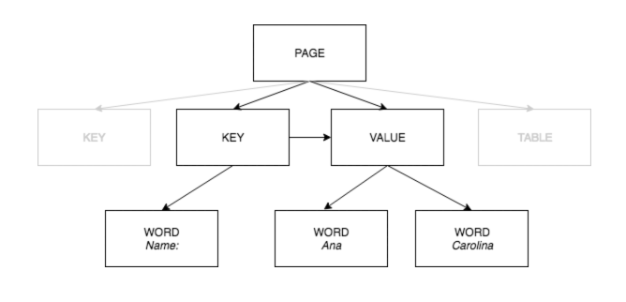

Code samples can be found at:

https://docs.aws.amazon.com/textract/latest/dg/examples-extract-kvp.html

In [1]:
import os
import boto3
import sys
import re
import json
from collections import defaultdict


def get_kv_map(file_name):
    with open(file_name, 'rb') as file:
        img_test = file.read()
        bytes_test = bytearray(img_test)
        print('Image loaded', file_name)

    # process using image bytes
    client = boto3.client('textract')
    response = client.analyze_document(Document={'Bytes': bytes_test}, FeatureTypes=['FORMS'])

    # Get the text blocks
    blocks = response['Blocks']

    # get key and value maps
    key_map = {}
    value_map = {}
    block_map = {}
    for block in blocks:
        block_id = block['Id']
        block_map[block_id] = block
        if block['BlockType'] == "KEY_VALUE_SET":
            if 'KEY' in block['EntityTypes']:
                key_map[block_id] = block
            else:
                value_map[block_id] = block

    return key_map, value_map, block_map


def get_kv_relationship(key_map, value_map, block_map):
    kvs = defaultdict(list)
    for block_id, key_block in key_map.items():
        value_block = find_value_block(key_block, value_map)
        key = get_text(key_block, block_map)
        val = get_text(value_block, block_map)
        kvs[key].append(val)
    return kvs


def find_value_block(key_block, value_map):
    for relationship in key_block['Relationships']:
        if relationship['Type'] == 'VALUE':
            for value_id in relationship['Ids']:
                value_block = value_map[value_id]
    return value_block


def get_text(result, blocks_map):
    text = ''
    if 'Relationships' in result:
        for relationship in result['Relationships']:
            if relationship['Type'] == 'CHILD':
                for child_id in relationship['Ids']:
                    word = blocks_map[child_id]
                    if word['BlockType'] == 'WORD':
                        text += word['Text'] + ' '
                    if word['BlockType'] == 'SELECTION_ELEMENT':
                        if word['SelectionStatus'] == 'SELECTED':
                            text += 'X '

    return text


def print_kvs(kvs):
    for key, value in kvs.items():
        print(key, ":", value)


def search_value(kvs, search_key):
    for key, value in kvs.items():
        if re.search(search_key, key, re.IGNORECASE):
            return value

#os.chdir ('/Users/ashishkumar/Documents/MDS/MAST90106_SM1/Comparison/Testing Code')
#cwd = os.getcwd()
file_name = 'mediumchart_1.png'

key_map, value_map, block_map = get_kv_map(file_name)

# Get Key Value relationship
kvs = get_kv_relationship(key_map, value_map, block_map)
print("\n\n== FOUND KEY : VALUE pairs ===\n")
print_kvs(kvs)

# Start searching a key value
#while input('\n Do you want to search a value for a key? (enter "n" for exit) ') != 'n':
    #search_key = input('\n Enter a search key:')
    #print('The value is:', search_value(kvs, search_key))'''


Image loaded mediumchart_1.png


== FOUND KEY : VALUE pairs ===

Medicine (print generic name)  : ['Zithrofranil ', '', '', '', '', '', '']
Date of birth:  : ['30/11/1992 ']
Indication  : ['', '', '', 'Aids/assists abdominal fat loss ', '', '', '']
Pharmacy  : ['', '', '', '', '', '', '']
Dose Hourly frequency  : ['capsule PRN ', 'PRN ', 'PRN ', 'PRN ', 'PRN ', 'PRN ', 'PRN ']
Address:  : ['Melbourne ']
M  : ['']
Max PRN dose/24 hrs  : ['', '', '', '', '', '', '']
Given names:  : ['Megan ']
Family name:  : ['Grant ']
F  : ['X ']
Date  : ['1/2/21 ', '', '', '', '', '', '', '1/2/13/5 ']
Contact  : ['', '', '', '', '', '', '']
URN:  : ['846 ']
Route  : ['Oral ', '', '', '', '', '']
Year:  : ['2021 ']
Print your name  : ['Evandras Europe ', '']
Prescriber signature Print your name  : ['', '', '', '', '']
Prescriber signature  : ['']
See front page for details  : ['As required PRN medications ']
